In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
DATA = pd.read_csv("blood_transfusion.csv")

===TASK 1: Data Visualization===

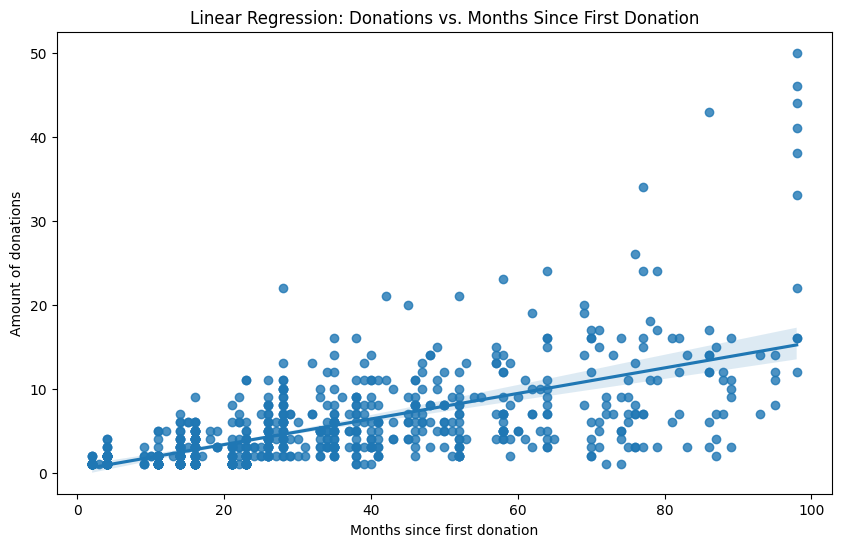

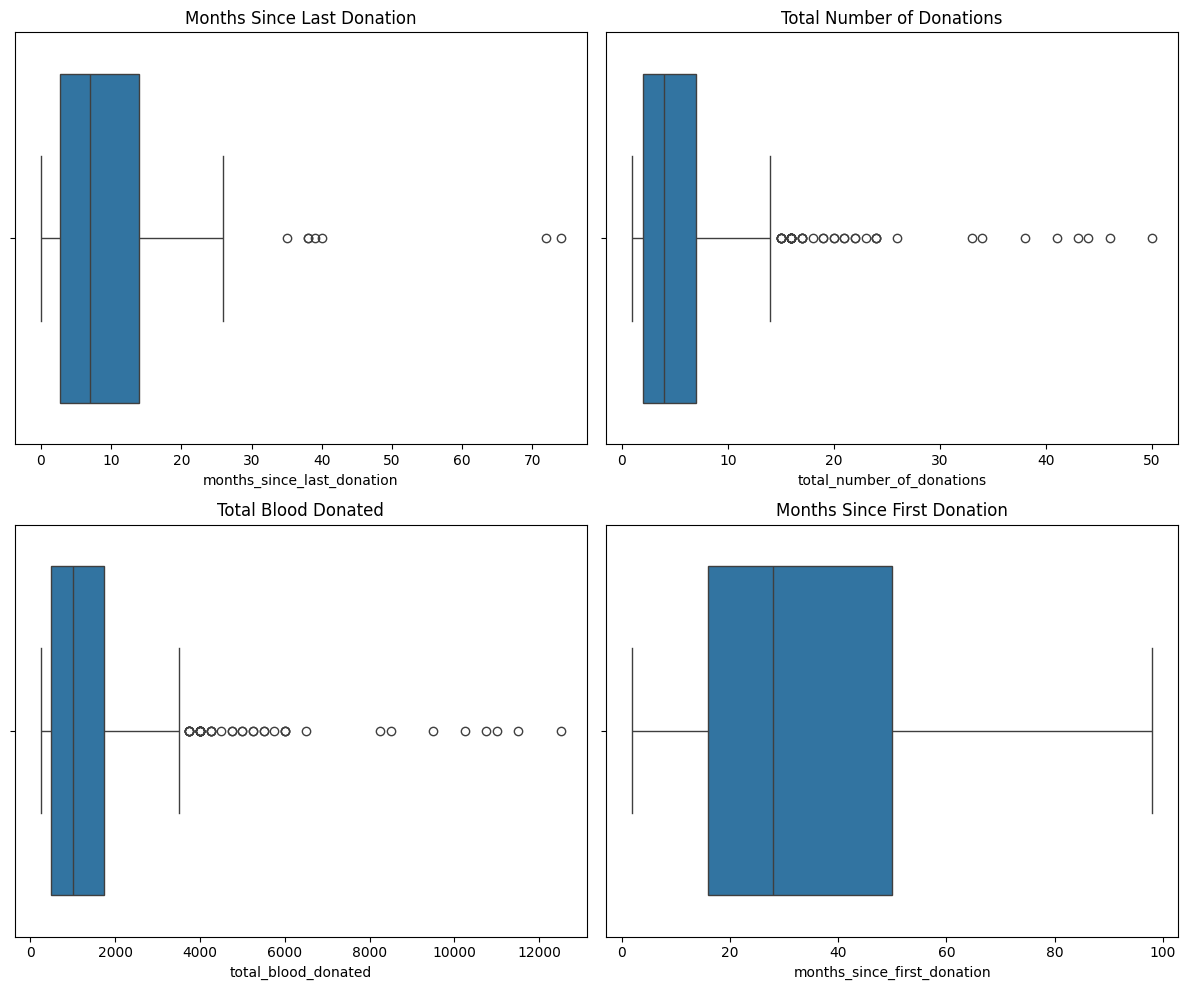

C:\Users\User\AppData\Local\Temp\ipykernel_10648\3777730629.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=DATA["class"], y=DATA["months_since_last_donation"], palette=["skyblue", "lightgreen"])


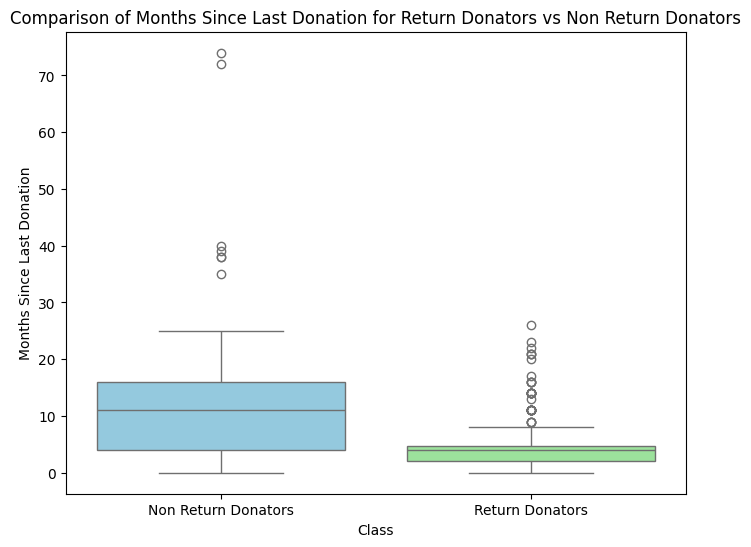

C:\Users\User\AppData\Local\Temp\ipykernel_10648\3777730629.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=DATA["class"], y=DATA["total_number_of_donations"], palette=["skyblue", "lightgreen"])


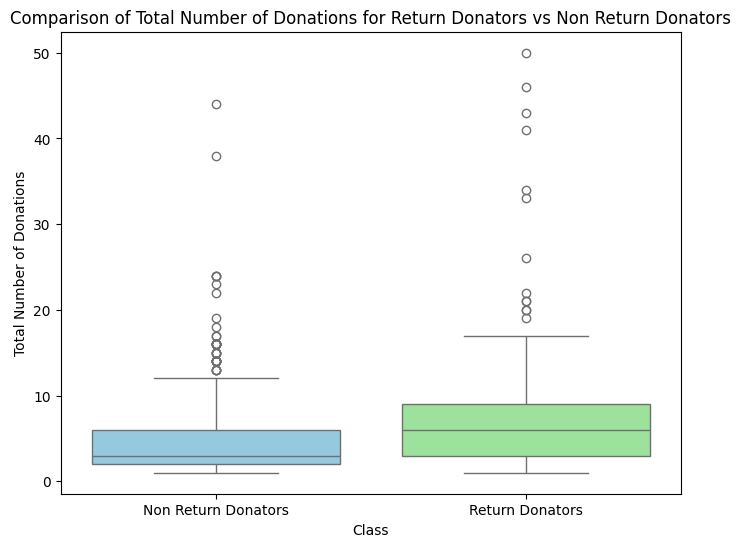

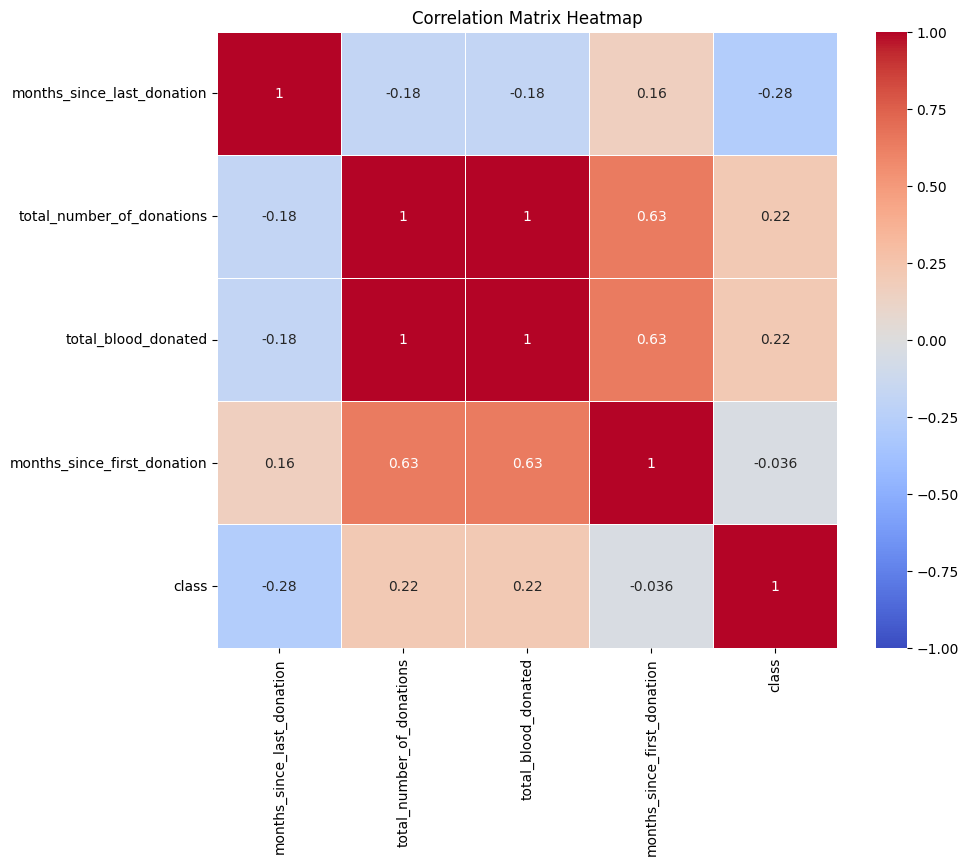

In [2]:
# Task 1.1 - Explore the dataset similarly to the first assignment, so you have a good understanding of 
# its content and features. Come up with an interesting one-minute story about the dataset.

# As part of task one, we will start trying to extract information from our data by combining features into explanitory visualizations.

months_since_first_donation = DATA["months_since_first_donation"]
total_number_of_donations = DATA["total_number_of_donations"]

# This particular visualization combines the the above two features to show that the increase in number of donations is actually quite linear with the time since their first donation.
# This means that people generally dont start donating more often when they have been donating for a longer time. We do however see more outliers from this trend the longer the time since the first donation is.

plt.figure(figsize=(10,6))
sns.regplot(x=months_since_first_donation, y=total_number_of_donations, scatter=True, fit_reg=True)
plt.xlabel("Months since first donation")
plt.ylabel("Amount of donations")
plt.title("Linear Regression: Donations vs. Months Since First Donation")
plt.show()

# Create box plots for each feature separately
# For the following features, we decided it would be informative to investigate the nature of the dataset in regards to these features. 
# The visualizations show that the features months since first donation are spread out more even, which is to be expected with a steady growing number of participants.
# However we do see a slight nudge to the left, telling us that less people are starting to donate now, then used to be. This can be explained by the possibility that
# the people in the area that would donate have already signed up.
# We can also see that the number of donations is visually exactly the same to the amount donated. Implying that the center is diligent in the amount of blood donated per donation.
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(ax=axes[0, 0], data=DATA, x='months_since_last_donation')
axes[0, 0].set_title('Months Since Last Donation')

sns.boxplot(ax=axes[0, 1], data=DATA, x='total_number_of_donations')
axes[0, 1].set_title('Total Number of Donations')

sns.boxplot(ax=axes[1, 0], data=DATA, x='total_blood_donated')
axes[1, 0].set_title('Total Blood Donated')

sns.boxplot(ax=axes[1, 1], data=DATA, x='months_since_first_donation')
axes[1, 1].set_title('Months Since First Donation')

plt.tight_layout()
plt.show()

# Task 1.2 - Create a visualization, which shows the characteristics of tuples of class 1, compared to 
# tuples of class 0.

# For Task 1.2 we are dividing the data based on which class the instances belong to so we can identify trends or differences between both classes.
# We can for example see that people from class one have generally been donating much more recently than those of class zero.
# Additionally, they are shown to have generally done more donations than people of class 0, although class 0 has some outliers coming to comparably number of donations as the outliers from class 1.
# Box plot for months since last donation for class 0 and 1 to see if there is a difference
plt.figure(figsize=(8, 6))
sns.boxplot(x=DATA["class"], y=DATA["months_since_last_donation"], palette=["skyblue", "lightgreen"])

plt.xlabel("Class")
plt.ylabel("Months Since Last Donation")
plt.title("Comparison of Months Since Last Donation for Return Donators vs Non Return Donators")
plt.xticks([0, 1], ['Non Return Donators', 'Return Donators'])  
plt.show()

# Box plot for total number of donations for class 0 and 1 to see if there is a difference
plt.figure(figsize=(8, 6))
sns.boxplot(x=DATA["class"], y=DATA["total_number_of_donations"], palette=["skyblue", "lightgreen"])

plt.xlabel("Class")
plt.ylabel("Total Number of Donations")
plt.title("Comparison of Total Number of Donations for Return Donators vs Non Return Donators")
plt.xticks([0, 1], ['Non Return Donators', 'Return Donators'])  
plt.show()

# Generate a correlation matrix to point out obvious correlations
corr_matrix = DATA.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.show()

===TASK 2: Preprocessing===

Think about the shape of the data that is used as input for classification algorithms. 
Use preprocessing techniques, which you deem necessary, to apply to this dataset.

In [3]:
DATA.info()
DATA.describe()
print(DATA.isnull().sum())

df = DATA
# Two features have more outliers, as seen in the skewed graph, for these we first conduct logarithmic normalization before min max normalization, as that helps to reduce the impact of outliers. We make this optional so we can observe the difference in accuracy by doing this.
lognormal = True

# We noticed in task 1 that we have 2 features that are directly correlated, so we added the option to drop one of them. This did not affect the classification much, so we chose to leave it out for the following tasks.
dropdoublefeat = False
if dropdoublefeat:
    DATA = DATA.drop(columns=['total_blood_donated'])
    skewed_features = ['total_number_of_donations']   

else:
    skewed_features = ['total_number_of_donations','total_blood_donated']  

for f in skewed_features:
    if lognormal:
        df[f] = df[f].astype(float)
        df[f] = np.log1p(DATA[f])

#We conduct min max normalization on all features to get them all to count evenly for the classification process, by putting them on a similar scale from 0 to 1. 
if dropdoublefeat:
    minmax_features = ['total_number_of_donations','months_since_last_donation','months_since_first_donation']
else:
    minmax_features = ['total_number_of_donations','total_blood_donated','months_since_last_donation','months_since_first_donation']
for f in minmax_features:
    df[f] = (df[f] - df[f].min()) /(df[f].max() - df[f].min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_since_last_donation   748 non-null    float64
 1   total_number_of_donations    748 non-null    float64
 2   total_blood_donated          748 non-null    float64
 3   months_since_first_donation  748 non-null    float64
 4   class                        748 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 29.3 KB
months_since_last_donation     0
total_number_of_donations      0
total_blood_donated            0
months_since_first_donation    0
class                          0
dtype: int64


===TASK 3: Creating a Train Set and a Test Set===

In [4]:
# Task 3.1 - Look for a function in the Sklearn documentation which can create train-test splits. Use 
# this function to create two train-test splits of different sizes. Throughout the entire PA keep 
# comparing the different splits and the impact they have on different tasks.

# Define the features and target variable
X = df[['months_since_last_donation', 'total_number_of_donations', 'total_blood_donated', 'months_since_first_donation']]
y = df['class']  # Class is the target variable as it says in the assignment


#We split in 80/20 and 50/50 so that there is a large difference between the two, so we can look at whether the large difference makes any significant difference. For example, 80/20 could lead to overfitting.
# First split: 80% train, 20% test
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 50% train, 50% test to show the difference with using less train data
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.3, random_state=42)

print("80/20 split: ", X_train_80.shape, X_test_20.shape)
print("70/30 split: ", X_train_50.shape, X_test_50.shape)

80/20 split:  (598, 4) (150, 4)
70/30 split:  (523, 4) (225, 4)


===TASK 4: Classification Algorithm===

We have used the created splits from the first assignment to test several classifying models.

From this we have concluded that all models score about the same on

In [11]:
# Task 4.1 - Manually implement a KNN classifier. You are not allowed to use any predefined functions 
# or libraries, except for auxiliary functionalities, such as the square root function of the Math 
# library.

#print(X_train_80.dtypes)
#print(X_test_80.dtypes)
#print(X_train_80.head())
#print(X_test_80.head())
#print(X_train_80.applymap(lambda x: isinstance(x, str)).any())  # Should return False
#print(X_test_80.applymap(lambda x: isinstance(x, str)).any())  

#We first define a function to get the euclidian distance between two points
def euclidean_distance(point1, point2):
    distance = 0.0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2  
    return distance ** 0.5  

# This function creates a list of the distances between every point in the test data and a given point. It then returns the first k distances in the list.
def get_k_nearest_neighbors(X_train, y_train, test_point, k):
    distances = []
    for i in range(len(X_train)):
        distance = euclidean_distance(X_train.iloc[i], test_point)  # Calculate distance
        distances.append((distance, y_train.iloc[i]))  # Store distance and corresponding class label
    
    # Sort the distances list by the distance value
    distances.sort(key=lambda x: x[0])
    
    # Get the K nearest neighbors and their class label
    k_nearest_neighbors = distances[:k]
    return k_nearest_neighbors

def predict_class(k_nearest_neighbors):
    class_votes = {}

    # Go over the k nearest neighbors and count their class labels
    for neighbor in k_nearest_neighbors:
        # Find class label of the neighbor
        label = neighbor[1]  
        if label in class_votes:
            class_votes[label] += 1
        else:
            class_votes[label] = 1
    
    # Find the class label with the most votes
    majority_class = max(class_votes, key=class_votes.get)
    return majority_class

def knn_classifier(X_train, y_train, X_test, k):
    predictions = []
    
    for index in range(len(X_test)):
        test_point = X_test.iloc[index]  # Get the test point
        k_nearest_neighbors = get_k_nearest_neighbors(X_train, y_train, test_point, k)  # Get K nearest neighbors
        predicted_class = predict_class(k_nearest_neighbors)  # Predict the class
        predictions.append(predicted_class)  # Store the prediction
    
    return predictions




# Predict using the KNN classifier on the 80/20 split
k = 7
predicted_labels_80 = knn_classifier(X_train_80, y_train_80, X_test_20, k)

# Calculate the accuracy
accuracy_80 = accuracy_score(y_test_20, predicted_labels_80)
print("Accuracy for 80% split using KNN:", accuracy_80)

# Show the first 5 actual and predicted labels for the 80/20 split
print("First 5 actual labels (80/20 split):", y_test_20[:5].tolist())
print("First 5 predicted labels (80/20 split):", predicted_labels_80[:5])

# Predict using the KNN classifier on the 50/50 split
predicted_labels_50 = knn_classifier(X_train_50, y_train_50, X_test_50, k)

# Calculate the accuracy
accuracy_50 = accuracy_score(y_test_50, predicted_labels_50)
print("Accuracy for 50% split using KNN:", accuracy_50)

# Show the first 5 actual and predicted labels for the 50/50 split
print("First 5 actual labels (50/50 split):", y_test_50[:5].tolist())
print("First 5 predicted labels (50/50 split):", predicted_labels_50[:5])
 
# Task 4.2 - Use Sklearn's Naive Bayes Classifier. Predict a few new cases and compare the predicted 
# labels with the actual labels. 

# First using the Naive Bayes Classifier on the 80/20 split
gaussian80_NB = GaussianNB()
gaussian80_NB.fit(X_train_80,y_train_80)

gnb80_predict_y = gaussian80_NB.predict(X_test_20)

gnb80_accuracy = accuracy_score(y_test_20,gnb80_predict_y)
print("On the 80/20 split the accuracy for GNB is:", gnb80_accuracy)

# showing the first 5 actual and predicted labels for the 80/20 split
print("First 5 actual labels:", y_test_20[:5])
print("First 5 predicted labels:", gnb80_predict_y[:5])

# Secondly using the Naive Bayes Classifier on the 50/50 split
gaussian50_NB= GaussianNB()
gaussian50_NB.fit(X_train_50,y_train_50)

gnb50_predict_y = gaussian50_NB.predict(X_test_50)

gnb50_accuracy = accuracy_score(y_test_50,gnb50_predict_y)
print("On the 50/50 split the accuracy for GNB is:", gnb50_accuracy)


# Task 4.3 - Use Sklearn's Support Vector Classifier. Predict a few new cases and compare the 
# predicted labels with the actual labels.

# First using SVC on the 80/20 split
sv80 = SVC()

sv80.fit(X_train_80,y_train_80)

sv80_predict_y = sv80.predict(X_test_20)

sv80_accuracy = accuracy_score(y_test_20,sv80_predict_y)

print("The accuracy of the SVC on the 80/20 split is:", sv80_accuracy)

print("First 5 actual labels:", y_test_20[:5])
print ("First 5 predicted labels:", sv80_predict_y[:5])

# Secondly using SVC on the 50/50 split
sv50 = SVC()

sv50.fit(X_train_50,y_train_50)

sv50_predict_y = sv50.predict(X_test_50)

sv50_accuracy = accuracy_score(y_test_50,sv50_predict_y)

print("The accuracy of the SVC on the 50/50 split is:", sv50_accuracy)

 
# Task 4.4 - Use Sklearn's Multilayer Perceptron (Neural Network) Classifier. Predict a few new cases 
# and compare the predicted labels with the actual labels.

# Firstly perfrom MLP on the 80/20 split
mlp80 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=11)

mlp80.fit(X_train_80,y_train_80)

mlp80_pred_y = mlp80.predict(X_test_20)

mlp80_accuracy = accuracy_score(y_test_20,mlp80_pred_y)

print("The accuracy for MLP on the 80/20 split is:", mlp80_accuracy)

print("First 5 actual labels:", y_test_20[:5])
print("First 5 predicted labels:",mlp80_pred_y [:5])

# Secondly perform MLP on the 50/50 split
mlp50 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=11)

mlp50.fit(X_train_50,y_train_50)

mlp50_pred_y = mlp50.predict(X_test_50)

mlp50_accuracy = accuracy_score(y_test_50,mlp50_pred_y)

print("The accuracy for MLP on the 50/50 split is:", mlp50_accuracy)



C:\Users\User\AppData\Local\Temp\ipykernel_10648\1544616489.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += (point1[i] - point2[i]) ** 2


Accuracy for 80% split using KNN: 0.76
First 5 actual labels (80/20 split): [0, 0, 0, 0, 0]
First 5 predicted labels (80/20 split): [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


C:\Users\User\AppData\Local\Temp\ipykernel_10648\1544616489.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += (point1[i] - point2[i]) ** 2


Accuracy for 50% split using KNN: 0.7511111111111111
First 5 actual labels (50/50 split): [0, 0, 0, 0, 0]
First 5 predicted labels (50/50 split): [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
On the 80/20 split the accuracy for GNB is: 0.7466666666666667
First 5 actual labels: 580    0
356    0
133    0
250    0
299    0
Name: class, dtype: int64
First 5 predicted labels: [0 0 0 0 0]
On the 50/50 split the accuracy for GNB is: 0.7377777777777778
The accuracy of the SVC on the 80/20 split is: 0.7533333333333333
First 5 actual labels: 580    0
356    0
133    0
250    0
299    0
Name: class, dtype: int64
First 5 predicted labels: [0 0 0 0 0]
The accuracy of the SVC on the 50/50 split is: 0.7333333333333333
The accuracy for MLP on the 80/20 split is: 0.7733333333333333
First 5 actual labels: 580    0
356    0
133    0
250    0
299    0
Name: class, dtype: int64
First 5 predicted labels: [0 0 0 0 0]
The accuracy for MLP on the 50/50 split is: 0.7511111111111111


Taking a look at the different accuracy scores accross models and splits to get a better idea of how these scores differ between models.

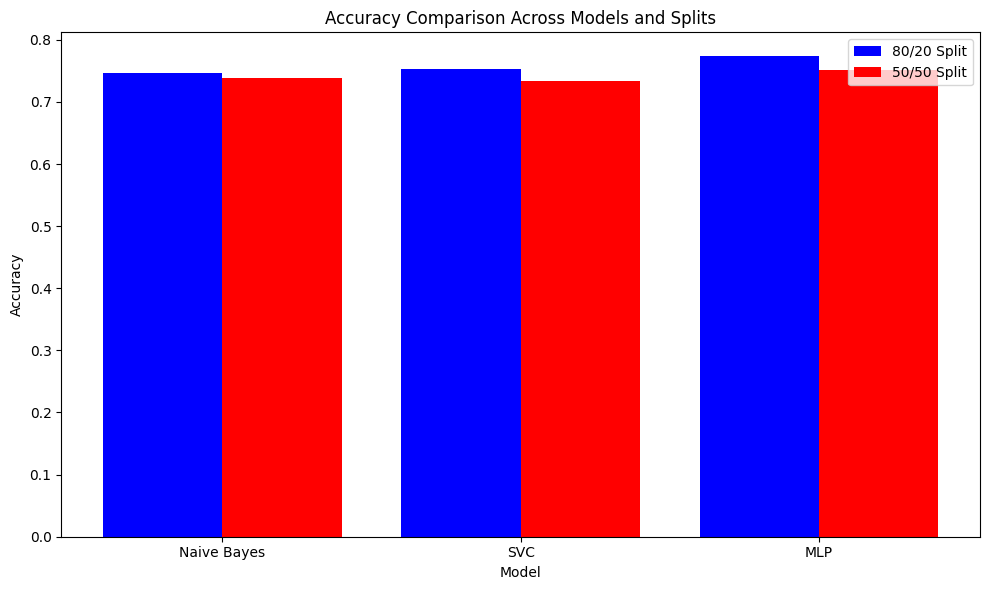

In [6]:
# different models and accuracies
models = ['Naive Bayes','SVC', 'MLP']
split_80 = [gnb80_accuracy, sv80_accuracy, mlp80_accuracy]
split_50 = [gnb50_accuracy, sv50_accuracy, mlp50_accuracy]

x = np. arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))


bars_80 = ax. bar(x - width/2, split_80, width, label='80/20 Split', color='blue')
bars_50 = ax. bar(x + width/2, split_50, width, label='50/50 Split', color='red')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison Across Models and Splits')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout ()
plt.show()

===TASK 5: Evaluation of Classification Methods===

For the next questions, use the already fitted/learned models from the previous task 
for the splits we have created in Task 3.

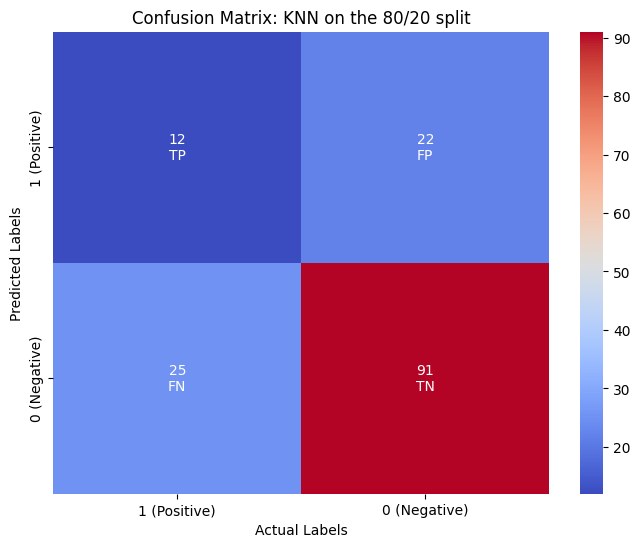

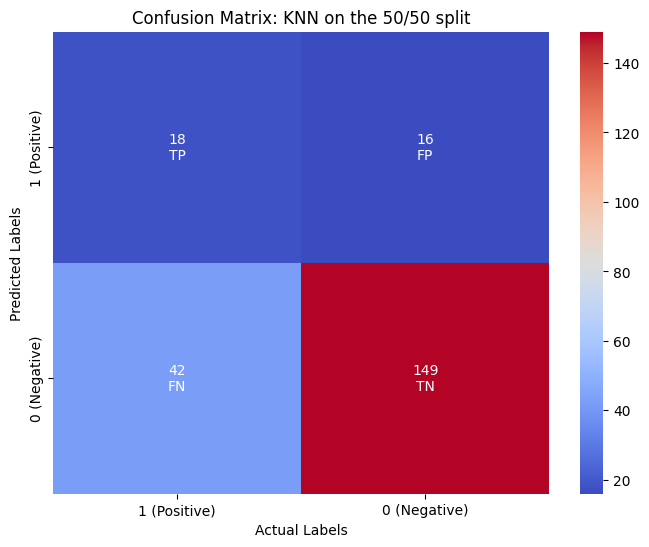

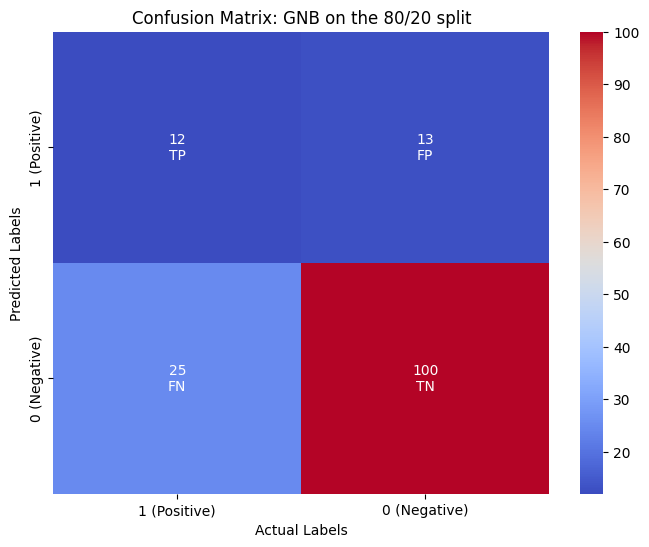

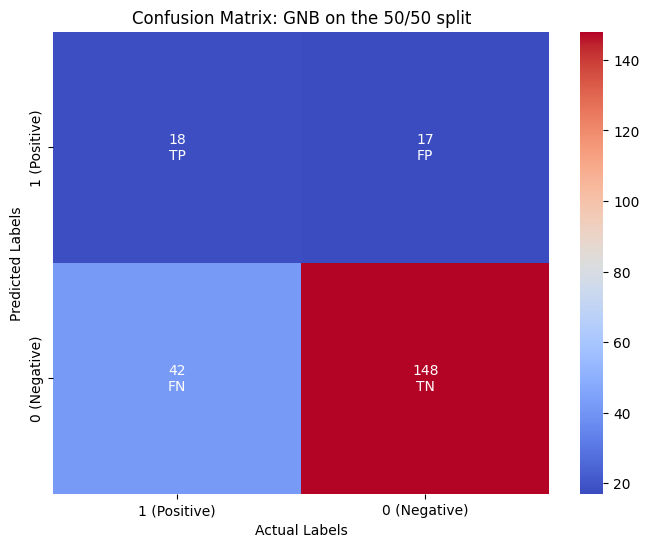

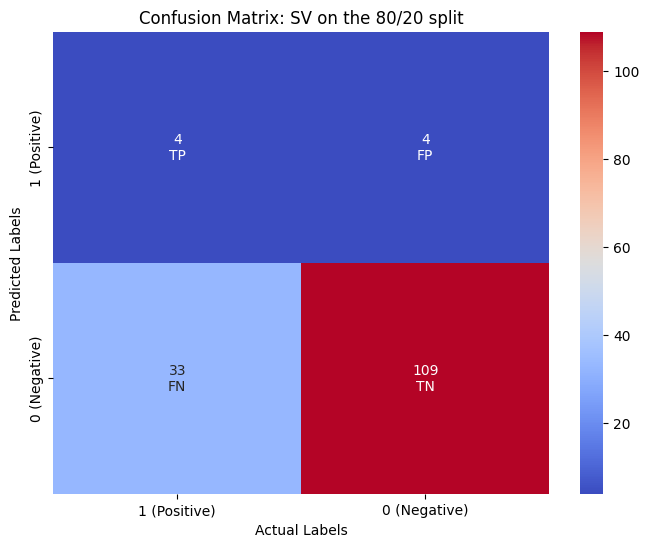

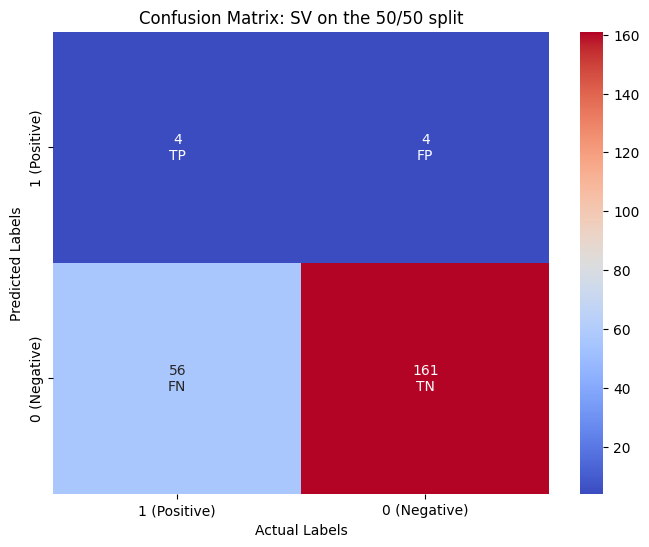

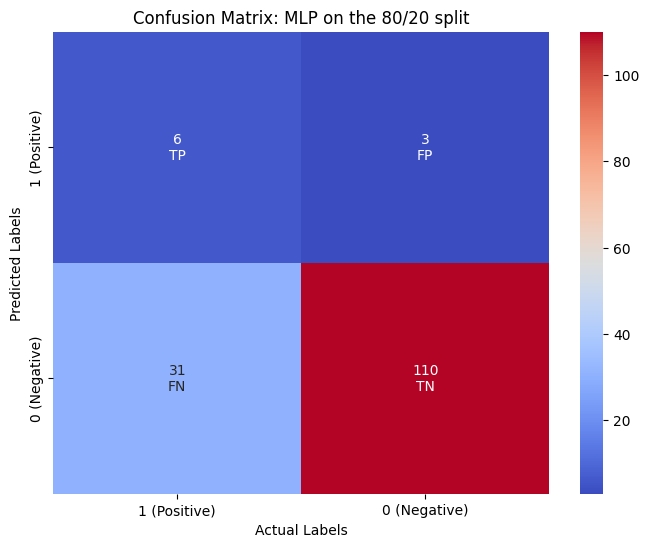

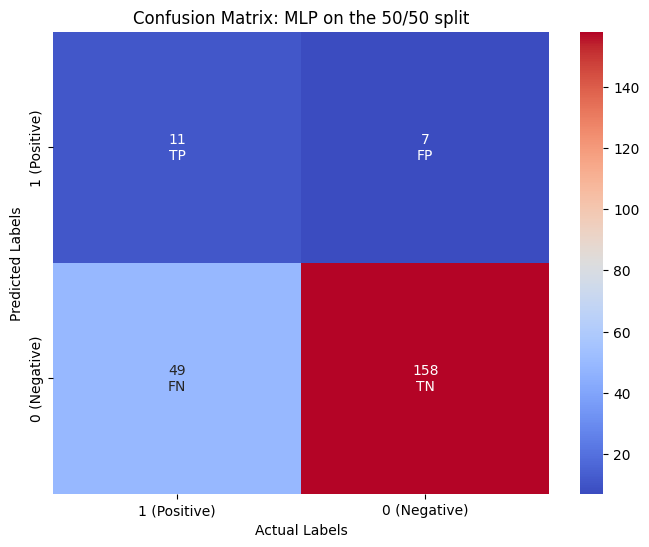

Classification report of KNN on the 80/20 split: 
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       113
           1       0.35      0.32      0.34        37

    accuracy                           0.69       150
   macro avg       0.57      0.56      0.57       150
weighted avg       0.68      0.69      0.68       150

Classification report of KNN on the 50/50 split: 
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       165
           1       0.53      0.30      0.38        60

    accuracy                           0.74       225
   macro avg       0.65      0.60      0.61       225
weighted avg       0.71      0.74      0.72       225

Classification report of GNB on the 80/20 split: 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       113
           1       0.48      0.32      0.39        37

    accuracy                 

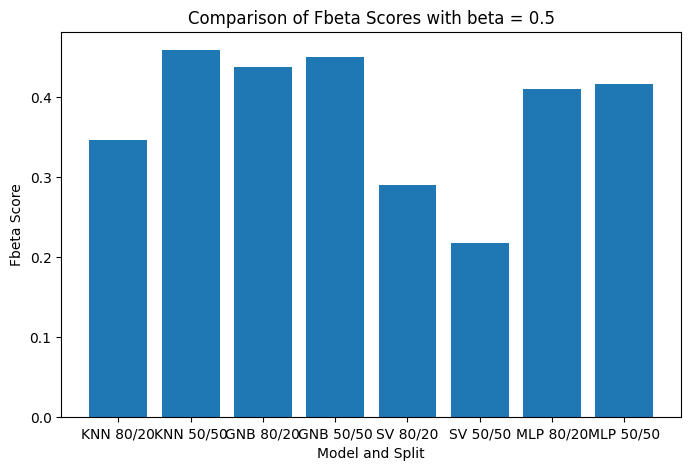

Fbeta score of KNN on the 80/20 split : 0.3380281690140845
Fbeta score of KNN on the 50/50 split : 0.3829787234042553
Fbeta score of GNB on the 80/20 split : 0.3870967741935484
Fbeta score of GNB on the 50/50 split : 0.37894736842105264
Fbeta score of SV on the 80/20 split : 0.17777777777777778
Fbeta score of SV on the 50/50 split : 0.11764705882352941
Fbeta score of MLP on the 80/20 split : 0.2608695652173913
Fbeta score of MLP on the 50/50 split : 0.28205128205128205
Fbeta score of GNB on the 80/20 split is the best


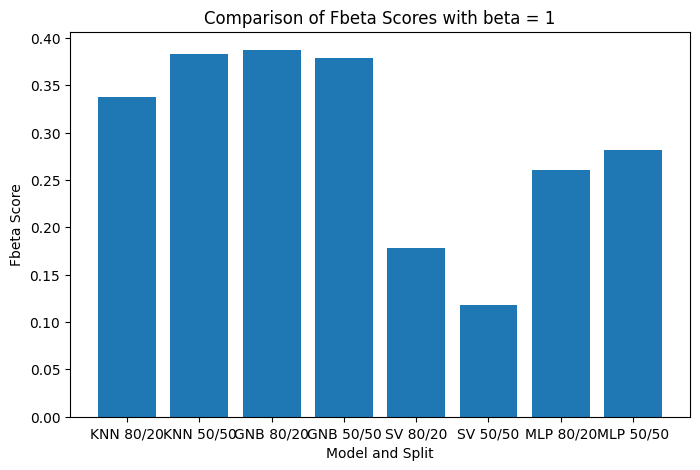

Fbeta score of KNN on the 80/20 split : 0.32967032967032966
Fbeta score of KNN on the 50/50 split : 0.3284671532846715
Fbeta score of GNB on the 80/20 split : 0.3468208092485549
Fbeta score of GNB on the 50/50 split : 0.32727272727272727
Fbeta score of SV on the 80/20 split : 0.1282051282051282
Fbeta score of SV on the 50/50 split : 0.08064516129032258
Fbeta score of MLP on the 80/20 split : 0.1910828025477707
Fbeta score of MLP on the 50/50 split : 0.2131782945736434
Fbeta score of GNB on the 80/20 split is the best


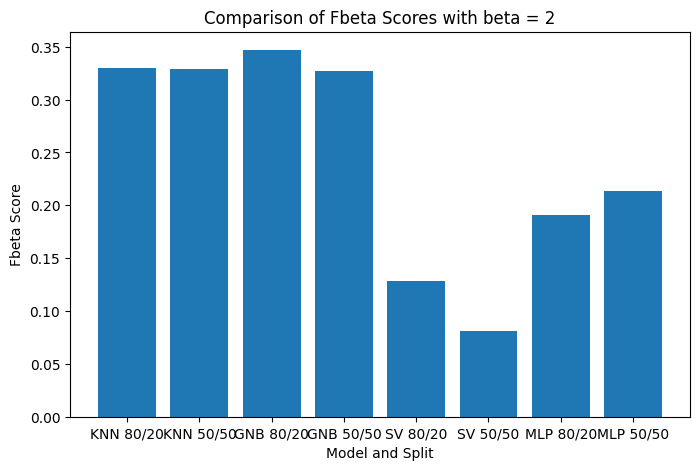

In [7]:
# Task 5.1 - Manually implement a confusion matrix to evaluate the results of the classification 
# models. You are not allowed to use any predefined functions or libraries.

# for task 5.1, we focus on evaluating the classifications of each classification algorithm which we have used.
# We use a number of methods to calculate metrics such as accuracy, precision, recall, f1-score and fbeta score

# One of the primary methods of evaluating classifications is by using a confusion matrix.
# The confusion matrix is a form of data visualization which provides us with information on the quality of a prediction made by a classification algorithm.
# It contains four categories, which contain the amount of predictions that fall under the respective category. The four categories are:
# 1. True Positive (Both the predicted and actual label are positive);
# 2. False Positive (The predicted label is positive while the actual one is negative);
# 3. False Negative (The predicted label is negative while the actual one is positive);
# 4. True Negative (Both the predicted and actual label are negative).


def create_confusion_matrix(y_test, y_prediction, message):

    classes = np.unique(y_test)
    n = len(classes)

    cm = np.zeros((n, n), dtype=int) # create a confusion matrix filled with zeros
    class_to_index = {label: idx for idx, label in enumerate(classes)} # dictionary which maps class to an index for the confusion matrix
    zipped_labels = zip(y_test, y_prediction) # zip result so we can compare


    for actual_label, pred_label in zipped_labels:
        true_idx = class_to_index[actual_label] # get index
        pred_idx = class_to_index[pred_label] # get index
        cm[1-pred_idx, 1-true_idx] += 1 # add 1 to according point in matrix
    
    # Plot the confusion matrix using seaborn for visualization

    names = np.empty((n, n), dtype=object)
    names[0, 0] = "TP"
    names[1, 0] = "FN"
    names[0, 1] = "FP"
    names[1, 1] = "TN"


    custom = np.empty((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            custom[i, j] = f"{cm[i, j]}\n{names[i, j]}"


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=custom, fmt="", cmap="coolwarm", xticklabels=["1 (Positive)", "0 (Negative)"], yticklabels=["1 (Positive)", "0 (Negative)"])
    plt.title("Confusion Matrix: "+message)
    plt.ylabel("Predicted Labels")
    plt.xlabel("Actual Labels")
    plt.show()

create_confusion_matrix(y_test_20, predicted_labels, "KNN on the 80/20 split")
create_confusion_matrix(y_test_50, predicted_labels50, "KNN on the 50/50 split")
create_confusion_matrix(y_test_20, gnb80_predict_y, "GNB on the 80/20 split")
create_confusion_matrix(y_test_50, gnb50_predict_y, "GNB on the 50/50 split")
create_confusion_matrix(y_test_20, sv80_predict_y, "SV on the 80/20 split")
create_confusion_matrix(y_test_50, sv50_predict_y, "SV on the 50/50 split")
create_confusion_matrix(y_test_20, mlp80_pred_y, "MLP on the 80/20 split")
create_confusion_matrix(y_test_50, mlp50_pred_y, "MLP on the 50/50 split")


# Task 5.2 - Use Sklearn's classification report function to evaluate the results of the classification 
# models.

# The sklearn's report function builds on the information presented in the confusion matrix. The confusion matrix creates a table,
# using this tabel we can calculate the following metrics:
# Accuracy: (TN + TP) / n Percentage of correctly classified data instances over all data instances
# Precision: TP / (TP + FP) What percentage of positive predictions is accurate
# Recall: TP / (TP + FN) Out of all actual positives, what percentage was predicted as such
# F1-score: (2 * (Precision * Recall)) / (Precision + Recall) Harmonic mean of Precision and Recall

# These metrics are all calculated in the report function, and allow us to compare the classifications

def make_classification_report(y_true, y_pred, message):
    report = classification_report(y_true, y_pred)
    print(message,"\n",report)

make_classification_report(y_test_20, predicted_labels, "Classification report of KNN on the 80/20 split:")
make_classification_report(y_test_50, predicted_labels50, "Classification report of KNN on the 50/50 split:")
make_classification_report(y_test_20, gnb80_predict_y, "Classification report of GNB on the 80/20 split:")
make_classification_report(y_test_50, gnb50_predict_y, "Classification report of GNB on the 50/50 split:")
make_classification_report(y_test_20, sv80_predict_y, "Classification report of SV on the 80/20 split:")
make_classification_report(y_test_50, sv50_predict_y, "Classification report of SV on the 50/50 split:")
make_classification_report(y_test_20, mlp80_pred_y, "Classification report of MLP on the 80/20 split:")
make_classification_report(y_test_50, mlp50_pred_y, "Classification report of MLP on the 50/50 split:")



# Task 5.3 - Use Sklearn's fbeta score function to evaluate the results of the classification models.

# The Fbeta score introduces a factor beta into the calculation of the f-score. Similar to the f1-score it calculates the harmonic mean of the precision and recall score.
# The factor allows for you to accent the importance of either the precision or recall score in the calculation of the f-score. A beta of 2 gives twice the importance to recall, and vice versa 0.5 gives twice the importance to precision.
# We compare the fbeta score of each algorithm for the following three beta values: 0.5, 1. 2

def get_fbeta_score(y_true, y_pred, message, b):
    score = fbeta_score(y_true, y_pred, beta=b) # beta at 2 makes recall twice as important as precision, 0.5 other way around
    print(message,":", score)
    return (score, message)

def make_fbeta_comparison(b):
    ls = []
    ls.append(get_fbeta_score(y_test_20, predicted_labels, "Fbeta score of KNN on the 80/20 split", b))
    ls.append(get_fbeta_score(y_test_50, predicted_labels50, "Fbeta score of KNN on the 50/50 split", b))
    ls.append(get_fbeta_score(y_test_20, gnb80_predict_y, "Fbeta score of GNB on the 80/20 split", b))
    ls.append(get_fbeta_score(y_test_50, gnb50_predict_y, "Fbeta score of GNB on the 50/50 split", b))
    ls.append(get_fbeta_score(y_test_20, sv80_predict_y, "Fbeta score of SV on the 80/20 split", b))
    ls.append(get_fbeta_score(y_test_50, sv50_predict_y, "Fbeta score of SV on the 50/50 split", b))
    ls.append(get_fbeta_score(y_test_20, mlp80_pred_y, "Fbeta score of MLP on the 80/20 split", b))
    ls.append(get_fbeta_score(y_test_50, mlp50_pred_y, "Fbeta score of MLP on the 50/50 split", b))

    #Compare the scores and print the best scoring clustering method
    maxscore = 0
    message = ""
    for score, test in ls:
        if score > maxscore:
            maxscore = score
            message = test
    print(message, "is the best")

    # Clean the strings and extract the values
    cleaned_labels = []
    values = []

    for score, test in ls:
        # Split and clean the string
        parts = test.split(' ')
        model_name = parts[3]  # Extract the model name
        split_info = parts[-2]  # Extract the split information
        cleaned_string = f"{model_name} {split_info}"
    
        cleaned_labels.append(cleaned_string)
        values.append(score)

    # Create the line plot
    plt.figure(figsize=(8, 5))
    plt.bar(cleaned_labels, values)

    # Add labels and title
    plt.xlabel('Model and Split')
    plt.ylabel('Fbeta Score')
    plt.title(f'Comparison of Fbeta Scores with beta = {b}')

    # Show the plot
    plt.show()

make_fbeta_comparison(0.5)
make_fbeta_comparison(1)
make_fbeta_comparison(2)

# From all these evaluation methods we have learned a couple of things.
# First of all, the MLP algorithm is shown to be the most precise, having a precision score of 0.75 on the 80/20 split, and a 0.72 on the 50/50 split.
# MLP also scores the best on recall, with a recall score of 0.77 on the 80/20 split, and a 0.75 on the 50/50 split.
# for the f1-score, the GNB algorithm does the best, with a score of 0.73 on the 80/20 split, and a 0.71 on te 50/50 split
# MLP on the 80/20 split is the winner on accuracy as wel, with a score of 0.77.
# MLP seems to perform the best, and the 80/20 split seems to always be better than the 50/50 split, no matter which algorithm
# This makes sense as with the 80/20, the algorithm has more data to train on.
# A top accuracy of 0.77 is still however a tad bit disappointing. For an algorithm to really become trustworthy we would like an accuracy of over 95%
# This is probably due to the lack of data, or lack of cohesion and predictability of the nature of the data.
# The GNB on 80/20 scores the highest fbeta score on a beta of 1 and 2, while KNN scores better on a beta of 0.5.
# This suggests that the KNN on the 50/50 split has higher precision.


===TASK 6: Cross-Validation===

Lastly, we performed both a 10 fold and a 5 fold cross validation to find the best value for the
'C' parameter.

From both of these models we found that the optimal 'C' value is 75.

Best parameter for SVC using 5 folds: {'C': 75}
Best parameter for SVC using 10 folds: {'C': 75}
Best accuracy for SVC using 5 folds after tuning: 0.7980939597315436
Best accuracy for SVC using 10 folds after tuning: 0.798054054054054


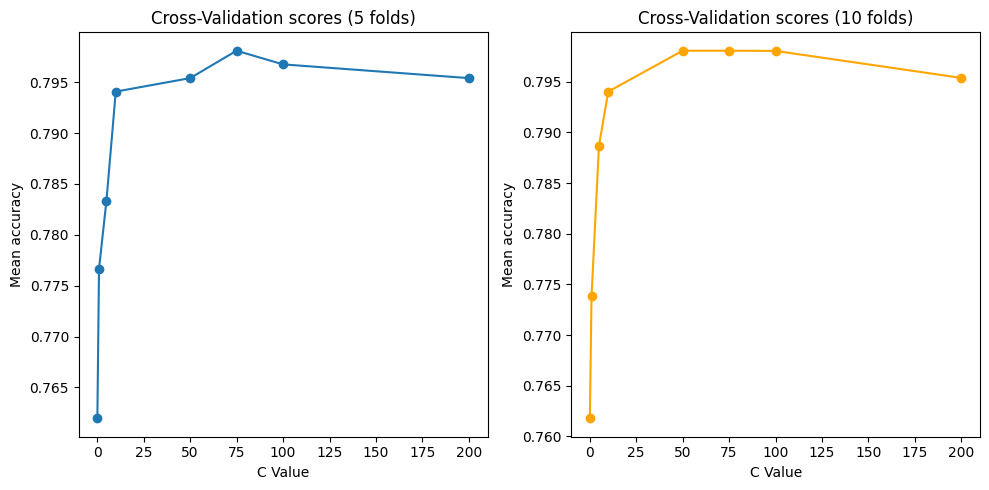

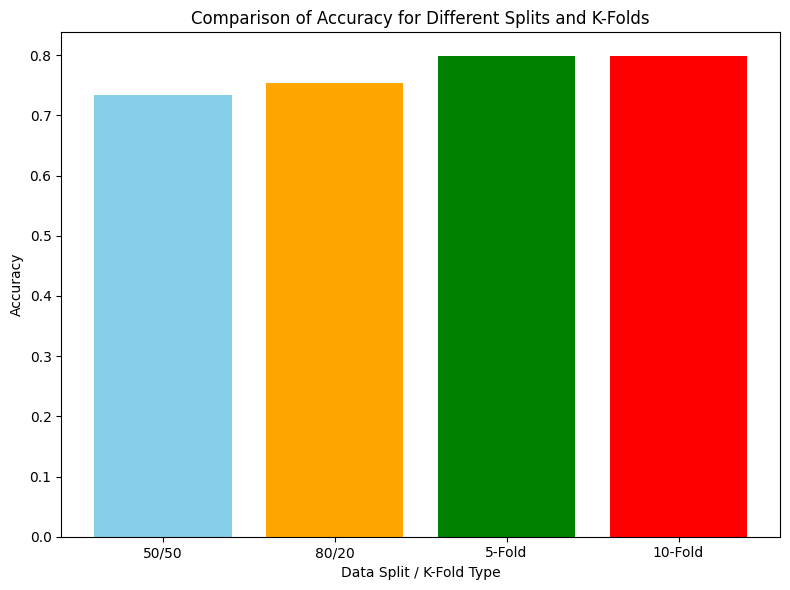

In [8]:
# creating predictors and target
X = df.drop('class', axis=1)  
y = df['class']

# defining KFolds, k=10 and k=5
kf5 = KFold(n_splits=5, shuffle=True, random_state=11)
kf10 = KFold(n_splits=10, shuffle=True, random_state=11)

# defining the parameter for the parameter search and its options
parameter_search = {'C': [0.1, 1, 5, 10, 50, 75, 100, 200]}

# applying gridsearch on both the Kfolds
svc_grid_5fold = GridSearchCV(SVC(), parameter_search, cv=kf5, scoring='accuracy')
svc_grid_5fold.fit(X, y)
svc_5fold_best_param = svc_grid_5fold.best_params_

svc_grid_10fold = GridSearchCV(SVC(), parameter_search, cv=kf10, scoring='accuracy')
svc_grid_10fold.fit(X, y)
svc_10fold_best_param = svc_grid_10fold.best_params_

# what is the best parameter found by the gridsearch
print("Best parameter for SVC using 5 folds:", svc_5fold_best_param)
print("Best parameter for SVC using 10 folds:", svc_10fold_best_param)

# refitting the SVC classifier with the best found C value
svc_5fold_best = SVC(C=svc_5fold_best_param['C'])
svc_5fold_best.fit(X, y)
svc_5fold_best_accuracy = svc_grid_5fold.best_score_

svc_10fold_best = SVC(C=svc_10fold_best_param['C'])
svc_10fold_best.fit(X, y)
svc_10fold_best_accuracy = svc_grid_10fold.best_score_

# On same C values the accuracy should be roughly the same
print("Best accuracy for SVC using 5 folds after tuning:", svc_5fold_best_accuracy)
print("Best accuracy for SVC using 10 folds after tuning:", svc_10fold_best_accuracy)


# Plotting mean accuracys for both KFolds
mean_scores_5fold = svc_grid_5fold.cv_results_['mean_test_score']
mean_scores_10fold = svc_grid_10fold.cv_results_['mean_test_score']
C_values = parameter_search['C']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(C_values, mean_scores_5fold, marker='o')
plt.title('Cross-Validation scores (5 folds)')
plt.xlabel('C Value')
plt.ylabel('Mean accuracy')

plt.subplot(1, 2, 2)
plt.plot(C_values, mean_scores_10fold, marker='o', color='orange')
plt.title('Cross-Validation scores (10 folds)')
plt.xlabel('C Value')
plt.ylabel('Mean accuracy')

plt.tight_layout()
plt.show()

# Comparing accuracies before and after applying KFold
average_scores = [sv50_accuracy, sv80_accuracy, svc_5fold_best_accuracy, svc_10fold_best_accuracy]
splits = ['50/50', '80/20', '5-Fold', '10-Fold']

# using differnt colors for each bar for better visibility
colors = ['skyblue', 'orange', 'green', 'red']  

x = np.arange(len(splits))  

plt.figure(figsize=(8, 6))
bars = plt.bar(x, average_scores, color=colors)

plt.xlabel('Data Split / K-Fold Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Splits and K-Folds')

plt.xticks(x, splits)

plt.tight_layout()
plt.show()



BONUS: Extra Code that could be useful for a client

In [9]:
# Bonus task 1 - Use Recursive Feature Elimination (RFE) with SVM to rank feature importance to get a better story for the client.


# First using SVC on the 80/20 split for feature ranking
svm = SVC(kernel="linear")

# Recursive Feature Elimination
rfe = RFE(estimator=svm, n_features_to_select=4)
rfe.fit(X_train_80, y_train_80)

# Getting the ranking of features
rfe_ranking_80 = pd.Series(rfe.ranking_, index=X_train_80.columns)
rfe_ranking_80 = rfe_ranking_80.sort_values()

print("Feature Ranking from SVM RFE on 80/20 split:\n", rfe_ranking_80)

# Now on the 50/50 split
rfe_50 = RFE(estimator=svm, n_features_to_select=1)
rfe_50.fit(X_train_50, y_train_50)

# Getting the ranking of features
rfe_ranking_50 = pd.Series(rfe_50.ranking_, index=X_train_50.columns)
rfe_ranking_50 = rfe_ranking_50.sort_values()

print("Feature Ranking from SVM RFE on 50/50 split:\n", rfe_ranking_50)

#Bonus task 2, train Logistic Regression models on both splits to rank features on importance
logreg80 = LogisticRegression()
logreg80.fit(X_train_80, y_train_80)

logreg50 = LogisticRegression()
logreg50.fit(X_train_50, y_train_50)

# Function to display feature importance from Logistic Regression model
def display_feature_importance(model, feature_names):
    coefficients = model.coef_[0] 
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    
    # Calculate absolute values of coefficients for importance ranking
    feature_importance['Importance'] = abs(feature_importance['Coefficient'])
    
    # Sort by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    print("Feature Importance:\n", feature_importance)

# Call the function for both splits
print("Feature Importance for 80/20 split:")
display_feature_importance(logreg80, X_train_80.columns)

print("\nFeature Importance for 50/50 split:")
display_feature_importance(logreg50, X_train_50.columns)

Feature Ranking from SVM RFE on 80/20 split:
 months_since_last_donation     1
total_number_of_donations      1
total_blood_donated            1
months_since_first_donation    1
dtype: int64
Feature Ranking from SVM RFE on 50/50 split:
 total_blood_donated            1
total_number_of_donations      2
months_since_last_donation     3
months_since_first_donation    4
dtype: int64
Feature Importance for 80/20 split:
Feature Importance:
                        Feature  Coefficient  Importance
0   months_since_last_donation    -2.745927    2.745927
3  months_since_first_donation    -2.225765    2.225765
1    total_number_of_donations     1.866153    1.866153
2          total_blood_donated     1.806550    1.806550

Feature Importance for 50/50 split:
Feature Importance:
                        Feature  Coefficient  Importance
0   months_since_last_donation    -2.716871    2.716871
3  months_since_first_donation    -1.896380    1.896380
1    total_number_of_donations     1.684332    1.684332